### Data Processing Pipeline for the Shanghai Telecom Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

from lib.problems import Generator

%matplotlib inline
sns.set()

In [3]:
# shanghai telecom data for 15 days (2014/06/01 - 2014/06/15)
load_pth = "./data/CCP/benchmark/shanghai_telecom/data_6-1_6-15_.xlsx"
save_raw_pth = "./data/CCP/benchmark/shanghai_telecom/data_aggr_raw.csv"
save_norm_pth = "./data/CCP/benchmark/shanghai_telecom/"

In [73]:
data_io = pd.read_excel(load_pth)

In [74]:
# remove rows with NAN coordinates
data_io.dropna(axis=0, inplace=True)

In [75]:
data_io.head

<bound method NDFrame.head of          month  date          start time            end time  \
0       201406     1 2014-06-01 10:22:36 2014-06-01 11:09:52   
1       201406     1 2014-06-01 07:00:37 2014-06-01 08:49:20   
2       201406     1 2014-06-01 02:49:16 2014-06-01 05:49:12   
3       201406     1 2014-06-01 08:51:58 2014-06-01 09:20:50   
4       201406     1 2014-05-31 23:49:10 2014-06-01 02:49:07   
...        ...   ...                 ...                 ...   
609397  201406    15 2014-06-15 08:25:37 2014-06-15 08:25:49   
609398  201406    15 2014-06-15 15:49:59 2014-06-15 15:50:27   
609399  201406    15 2014-06-15 04:39:41 2014-06-15 04:40:01   
609400  201406    15 2014-06-15 05:49:19 2014-06-15 05:49:55   
609401  201406    15 2014-06-15 20:13:25 2014-06-15 20:32:19   

       location(latitude/lontitude)                           user id  
0              31.237872/121.470259  edbc54bddf16494a49f39ac057b4185d  
1              31.237872/121.470259  f8206ab58b9bdb070673

In [76]:
# calculate session length in seconds and minutes from datetime stamps
data_io["session_length"] = (data_io["end time"] - data_io["start time"]).astype('timedelta64[s]')
data_io["session_length_minutes"] = np.ceil(data_io["session_length"] / 60)

In [77]:
# group df by location to get different base stations
grp_data = data_io.groupby(["location(latitude/lontitude)"])

In [78]:
# aggregate session lengths
grp_agg = grp_data.agg([np.sum, np.mean])
grp_agg[["session_length", "session_length_minutes"]].describe()


session_length               session_length_minutes             
                 sum          mean                    sum         mean
count   2.769000e+03   2769.000000            2769.000000  2769.000000
mean    4.756152e+05   2561.346696            8027.433008    43.180186
std     6.239992e+05   1616.445625           10521.344124    26.921684
min     1.100000e+01     11.000000               1.000000     1.000000
25%     3.650100e+04   1630.090909             619.000000    27.678322
50%     2.195780e+05   2278.333333            3716.000000    38.470930
75%     6.896290e+05   3063.636612           11615.000000    51.600000
max     6.221988e+06  10800.000000          104614.000000   180.000000

In [79]:
# aggregate num of unique users
grp_unq = grp_data.agg(['nunique'])
grp_unq["user id"].describe()

,nunique
count,2769.000000
mean,24.059588
std,27.694251
min,1.000000
25%,4.000000
50%,15.000000
75%,36.000000
max,356.000000


In [80]:
bs_table = pd.concat([
    grp_unq["user id"],
    grp_agg["session_length_minutes"],
], axis=1)
bs_table.reset_index(inplace=True)

In [81]:
# split location string into x/y coordinates
bs_table[["y_coord", "x_coord"]] = bs_table["location(latitude/lontitude)"].str.split("/", expand=True).astype(np.float64)

In [82]:
# replace location string with integer id
bs_table["location(latitude/lontitude)"] = np.arange(len(bs_table))

In [83]:
# rename columns
bs_table.columns = [
    "bs_id",
    "num_users",
    "workload",
    "workload_mean",
    "y_coord",
    "x_coord"
]

In [84]:
# drop all entries with coordinates far outside the main city.
# we look at the area between lat(30.5, 31.75) and lon(120.75, 122)
bs_table = bs_table[(120.75 <= bs_table["x_coord"]) & (bs_table["x_coord"]<= 122)]
bs_table = bs_table[(30.5 <= bs_table["y_coord"]) & (bs_table["y_coord"]<= 31.75)]
bs_table.reset_index(inplace=True, drop=True)

In [85]:
bs_table.describe()

,bs_id,num_users,workload,workload_mean,y_coord,x_coord
count,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000,2739.000000
mean,1381.106243,24.032129,7998.706097,43.156257,31.181791,121.434087
std,790.990059,27.700403,10471.979218,26.982069,0.143502,0.150414
min,12.000000,1.000000,1.000000,1.000000,30.705762,120.901878
25%,696.500000,3.000000,615.500000,27.670337,31.124291,121.367493
50%,1381.000000,15.000000,3721.000000,38.440860,31.218716,121.449083
75%,2065.500000,36.000000,11603.500000,51.575956,31.264937,121.515190
max,2751.000000,356.000000,104614.000000,180.000000,31.571904,121.922883


In [86]:
# save aggregated raw data
bs_table.to_csv(save_raw_pth, index=False)


Do some prior analysis and plots

In [87]:
bs_table = pd.read_csv(save_raw_pth)
bs_table

,bs_id,num_users,workload,workload_mean,y_coord,x_coord
0,12,16,6437.0,28.608889,30.705762,121.335120
1,13,30,21911.0,38.918295,30.715526,121.351073
2,14,12,1523.0,69.227273,30.716044,121.291037
3,15,36,28814.0,41.941776,30.716187,121.349498
4,16,13,2506.0,54.478261,30.718108,121.283169
...,...,...,...,...,...,...
2734,2747,17,2678.0,60.863636,31.492988,121.292044
2735,2748,2,2.0,1.000000,31.497375,121.324955
2736,2749,5,339.0,42.375000,31.501733,121.334549
2737,2750,5,516.0,51.600000,31.505950,121.282812


In [88]:
# remove all bs which have only 1 user or less than 5min usage in 15 days
# 2769 -> 2399 bs
bs_table = bs_table[bs_table["num_users"] > 1]
bs_table = bs_table[bs_table["workload"] >= 5]
bs_table.describe()

,bs_id,num_users,workload,workload_mean,y_coord,x_coord
count,2373.000000,2373.000000,2373.00000,2373.000000,2373.000000,2373.000000
mean,1361.104509,27.583228,9160.31437,42.175883,31.176885,121.431001
std,813.614515,28.130004,10783.45947,20.269413,0.148854,0.155238
min,12.000000,2.000000,6.00000,1.120000,30.705762,120.907525
25%,641.000000,7.000000,1275.00000,29.204082,31.111061,121.355749
50%,1336.000000,20.000000,5184.00000,39.053191,31.215347,121.445984
75%,2088.000000,40.000000,13387.00000,50.525424,31.267266,121.515041
max,2750.000000,356.000000,104614.00000,165.333333,31.505950,121.922883


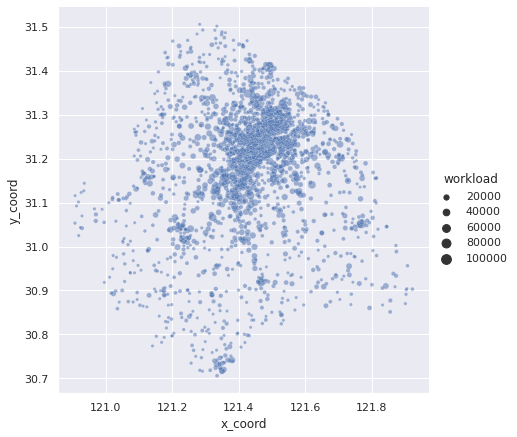

In [89]:
sns.relplot(x="x_coord", y="y_coord", size="workload",
            sizes=(10, 100), alpha=.5, palette="muted",
            height=6, data=bs_table)


Normalize data

In [68]:
# normalize coordinates
bs_table["x_coord"] = bs_table["x_coord"] - bs_table["x_coord"].min()
bs_table["y_coord"] = bs_table["y_coord"] - bs_table["y_coord"].min()
max_val = max(bs_table["x_coord"].max(), bs_table["y_coord"].max())
bs_table["x_coord"] = bs_table["x_coord"] / max_val
bs_table["y_coord"] = bs_table["y_coord"] / max_val

In [69]:
# The maximum capacity is given by total workload divided by number of edge servers times a factor
# the factor controls how tight the capacity constraint is
max_cap_factors = [1.05, 1.1, 1.2, 1.5]
k = 40  # we fix the number of ES to 40
total_workload = bs_table["workload"].sum()

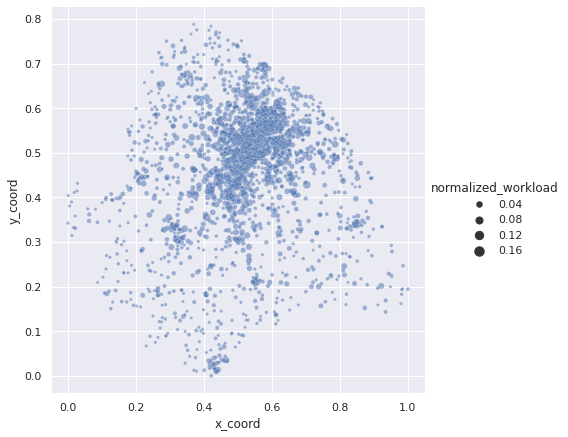

In [71]:
normalizer = np.ceil((total_workload / k) * 1.05)
bs_table["normalized_workload"] = bs_table["workload"] / normalizer
sns.relplot(x="x_coord", y="y_coord", size="normalized_workload",
            sizes=(10, 100), alpha=.5, palette="muted",
            height=6, data=bs_table)


In [72]:
# normalize with different capacity factors and save as np array
for f in max_cap_factors:
    # normalize workload
    normalizer = np.ceil((total_workload / k) * f)
    bs_table["normalized_workload"] = bs_table["workload"] / normalizer
    save_table = bs_table[["num_users", "x_coord", "y_coord", "normalized_workload"]]
    # save as csv
    save_table.to_csv(os.path.join(save_norm_pth, f"data_norm_cap{f}_.csv"))
    # convert to numpy array
    save_array = save_table.to_numpy(copy=True)
    # save as serialized data
    Generator.save_dataset(save_array, filepath=os.path.join(save_norm_pth, f"data_norm_cap{f}_.dat"))


Saving dataset to:  data/CCP/benchmark/shanghai_telecom/data_norm_cap1.05_.dat
Saving dataset to:  data/CCP/benchmark/shanghai_telecom/data_norm_cap1.1_.dat
Saving dataset to:  data/CCP/benchmark/shanghai_telecom/data_norm_cap1.2_.dat
Saving dataset to:  data/CCP/benchmark/shanghai_telecom/data_norm_cap1.5_.dat
